In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import wandb

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, ModuleList
from torch_geometric.nn import GATConv
from torch_geometric.utils import degree
from torch_geometric.nn import global_mean_pool

import functions as f

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
os.environ['WANDB_NOTEBOOK_NAME']="GAT.ipynb"

In [3]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads, nbr_classes):
        super(GAT, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        # self.double_mlp = Sequential(Linear(hidden_channels * heads, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.mlp = Sequential(Linear(hidden_channels * heads, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.elu(x)  # Using ELU activation for GAT
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

In [4]:
# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = True
if matrixprofile:
    in_channels = 461 + int(age) + int(sex)
else:
    in_channels = 5 + int(age) + int(sex)
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight, sex=sex, age=age, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset)


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.4
Correlation Method: pearson
Number of features: 461
Number of classes: 4

Data(edge_index=[2, 1410], weight=[1410], x=[116, 461], y=[1], num_nodes=116)
Number of nodes: 116
Number of edges: 1410
Average node degree: 12.16
Has isolated nodes: True
Has self-loops: True
Is undirected: True


In [5]:
# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# Training the model
def train(model, optimizer, criterion, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Alzheimers_GNN",
        # track hyperparameters and run metadata
        config = {
        "architecture": "GAT",
        "weights": weight,
        "matrix profiling": matrixprofile,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "heads": parameters[4],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Test Loss": test_losses[-1], "Test Accuracy": test_accuracies[-1]})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies= f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, train_losses, train_accuracies, valid_losses, valid_accuracies)
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1]})

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    heads = parameters[4]
    if matrixprofile:
        filename = f'GAT_Models_MP/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_heads{heads}.png'
    else:
        filename = f'GAT_Models/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_heads{heads}.png'
    plt.savefig(filename)
    plt.show()

    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies

GAT(
  (convs): ModuleList(
    (0): GATConv(461, 32, heads=2)
    (1-2): 2 x GATConv(64, 32, heads=2)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: mathilde-cros (alzheimers-cl). Use `wandb login --relogin` to force relogin


Epoch 1/1000
Train Loss: 6.4718, Validation Loss: 8.6895
Train Accuracy: 0.0972, Validation Accuracy: 0.0500
Epoch 2/1000
Train Loss: 5.7394, Validation Loss: 8.3259
Train Accuracy: 0.1512, Validation Accuracy: 0.0500
Epoch 3/1000
Train Loss: 5.6853, Validation Loss: 7.9382
Train Accuracy: 0.1512, Validation Accuracy: 0.0500
Epoch 4/1000
Train Loss: 5.1801, Validation Loss: 7.5084
Train Accuracy: 0.1250, Validation Accuracy: 0.0500
Epoch 5/1000
Train Loss: 4.8517, Validation Loss: 7.1536
Train Accuracy: 0.1582, Validation Accuracy: 0.0500
Epoch 6/1000
Train Loss: 4.3390, Validation Loss: 6.7691
Train Accuracy: 0.1597, Validation Accuracy: 0.0500
Epoch 7/1000
Train Loss: 4.1690, Validation Loss: 6.3768
Train Accuracy: 0.1790, Validation Accuracy: 0.0500
Epoch 8/1000
Train Loss: 3.9285, Validation Loss: 6.0274
Train Accuracy: 0.1651, Validation Accuracy: 0.0500
Epoch 9/1000
Train Loss: 3.4937, Validation Loss: 5.7315
Train Accuracy: 0.2346, Validation Accuracy: 0.0500
Epoch 10/1000
Train

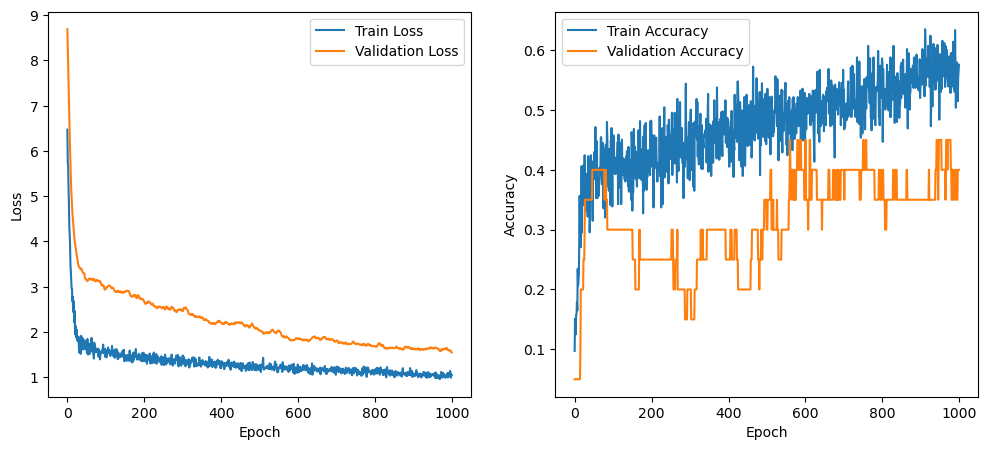

In [7]:
# Defining the model, optimizer and loss function
lr=0.00001
hidden_channels=32
dropout=0.2
num_layers=3
heads=2
parameters = [lr, hidden_channels, num_layers, dropout, heads]

model = GAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=1000)

Train Accuracy,▁▄▅▃▅▅▄▅▆▅▅▆▄▅▆▆▅▆▆▇▆▅▆▆▆▆▇▆▆▇▆▆▇▇▆▇███▆
Train Loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▇▇▅▅▄▅▅▅▅▄▃▅▅▅▅▄▅▅▇▅▇▇▆▆▆▆▇▆▇▇▆▆▆▆▆██▇
Validation Loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.57562
Train Loss,1.05159
Validation Accuracy,0.4
Validation Loss,1.54916


Epoch 1/500
Train Loss: 10.5792, Validation Loss: 10.0197
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 2/500
Train Loss: 10.0342, Validation Loss: 9.2508
Train Accuracy: 0.4938, Validation Accuracy: 0.5500
Epoch 3/500
Train Loss: 8.5064, Validation Loss: 8.4966
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 4/500
Train Loss: 7.8289, Validation Loss: 7.7619
Train Accuracy: 0.4830, Validation Accuracy: 0.5500
Epoch 5/500
Train Loss: 6.7516, Validation Loss: 7.1490
Train Accuracy: 0.4815, Validation Accuracy: 0.5000
Epoch 6/500
Train Loss: 5.9574, Validation Loss: 6.7894
Train Accuracy: 0.4367, Validation Accuracy: 0.4500
Epoch 7/500
Train Loss: 5.6401, Validation Loss: 6.5838
Train Accuracy: 0.4059, Validation Accuracy: 0.4000
Epoch 8/500
Train Loss: 5.7417, Validation Loss: 6.3481
Train Accuracy: 0.3472, Validation Accuracy: 0.4000
Epoch 9/500
Train Loss: 5.7359, Validation Loss: 6.0930
Train Accuracy: 0.3858, Validation Accuracy: 0.4500
Epoch 10/500
Train Loss: 

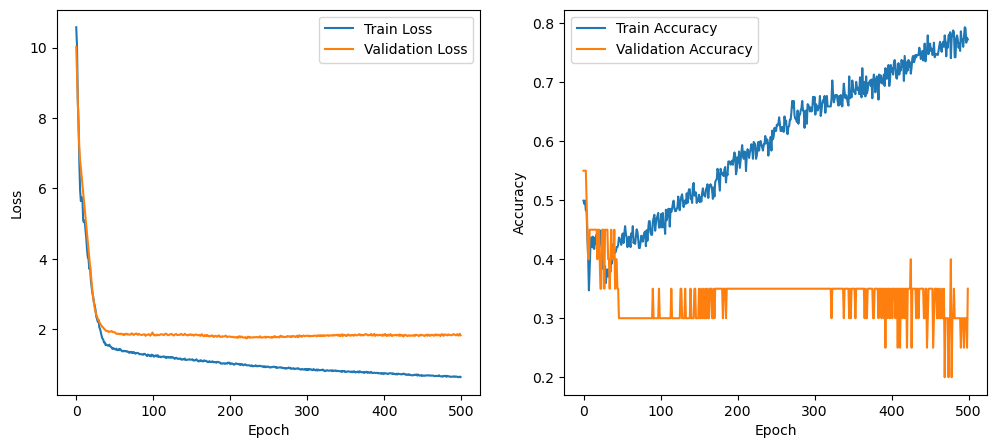

Train Accuracy,▃▂▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇█▇▇▇█
Train Loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▅▂▄▁▁▁▁▁▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
Validation Loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.77238
Train Loss,0.64038
Validation Accuracy,0.35
Validation Loss,1.82692


Epoch 1/500
Train Loss: 24.8812, Validation Loss: 30.5719
Train Accuracy: 0.2276, Validation Accuracy: 0.1000
Epoch 2/500
Train Loss: 23.3181, Validation Loss: 28.7929
Train Accuracy: 0.2384, Validation Accuracy: 0.1000
Epoch 3/500
Train Loss: 22.0274, Validation Loss: 27.1149
Train Accuracy: 0.2276, Validation Accuracy: 0.1000
Epoch 4/500
Train Loss: 20.1496, Validation Loss: 25.5114
Train Accuracy: 0.2330, Validation Accuracy: 0.1000
Epoch 5/500
Train Loss: 19.3192, Validation Loss: 23.9983
Train Accuracy: 0.2330, Validation Accuracy: 0.1000
Epoch 6/500
Train Loss: 17.9133, Validation Loss: 22.5045
Train Accuracy: 0.2369, Validation Accuracy: 0.1000
Epoch 7/500
Train Loss: 17.2733, Validation Loss: 21.0713
Train Accuracy: 0.2153, Validation Accuracy: 0.1000
Epoch 8/500
Train Loss: 15.7636, Validation Loss: 19.6384
Train Accuracy: 0.2191, Validation Accuracy: 0.1000
Epoch 9/500
Train Loss: 14.8782, Validation Loss: 18.2238
Train Accuracy: 0.2137, Validation Accuracy: 0.1000
Epoch 10/5

KeyboardInterrupt: 

In [8]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

MP = True

# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
#     'hidden_channels': [128, 64, 32],
#     'num_layers': [3, 2, 1],
#     'dropout_rate': [0.3, 0.2, 0.1, 0.0],
#     'heads': [5, 4, 3, 2]
# }
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
    'hidden_channels': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'heads': [2, 3, 4, 5]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 500
# Train using each combination
for params in param_combinations:
    if MP:
        filename = f'GAT_Models_MP/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_heads{params["heads"]}.png'
    else:
        filename = f'GAT_Models/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_heads{params["heads"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate'], params['heads']]
        model = GAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
        criterion = torch.nn.CrossEntropyLoss()
        train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=n_epochs)

